In [ ]:
!pip install mediapipe opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found exis

# FINAL CODE

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from collections import deque

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

In [ ]:
# Thresholds
EAR_THRESH = 0.25
MOR_THRESH = 0.5
NLR_THRESH = 15

In [ ]:
# Segment settings
FRAMES_PER_SEGMENT = 30   # ~1 sec if 30 fps
CONSECUTIVE_SEGMENTS = 3

# Buffers
frame_buffer = deque(maxlen=FRAMES_PER_SEGMENT)
segment_results = []   # store segment results for CSV


In [ ]:
# ---- Feature Calculation Functions ----
def eye_aspect_ratio(landmarks, eye_indices, w, h):
    pts = [(int(landmarks[i].x*w), int(landmarks[i].y*h)) for i in eye_indices]
    A = np.linalg.norm(np.array(pts[1]) - np.array(pts[5]))
    B = np.linalg.norm(np.array(pts[2]) - np.array(pts[4]))
    C = np.linalg.norm(np.array(pts[0]) - np.array(pts[3]))
    return (A+B) / (2.0*C)


In [ ]:
def mouth_opening_ratio(landmarks, w, h):
    top = np.array([landmarks[13].x*w, landmarks[13].y*h])
    bottom = np.array([landmarks[14].x*w, landmarks[14].y*h])
    left = np.array([landmarks[78].x*w, landmarks[78].y*h])
    right = np.array([landmarks[308].x*w, landmarks[308].y*h])
    return np.linalg.norm(top-bottom) / np.linalg.norm(left-right)

In [ ]:
def nose_length_ratio(landmarks, w, h):
    tip = np.array([landmarks[1].x*w, landmarks[1].y*h])
    bridge = np.array([landmarks[168].x*w, landmarks[168].y*h])
    return np.linalg.norm(tip-bridge)

In [ ]:
# ---- Load Video (Replace with your dataset path) ----
video_path = "/content/Himanshu_New_Dataset.mp4"   # change this to your dataset video
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = 0
segment_count = 0


In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    h, w = frame.shape[:2]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    drowsy_frame = 0
    if results.multi_face_landmarks:
        for landmarks in results.multi_face_landmarks:
            lm = landmarks.landmark
            # EAR
            left_eye_idx = [33,160,158,133,153,144]
            right_eye_idx = [362,385,387,263,373,380]
            ear = (eye_aspect_ratio(lm,left_eye_idx,w,h)+eye_aspect_ratio(lm,right_eye_idx,w,h))/2
            # MOR
            mor = mouth_opening_ratio(lm,w,h)
            # NLR
            nlr = nose_length_ratio(lm,w,h)

            # Threshold check
            if ear < EAR_THRESH or mor > MOR_THRESH or nlr < NLR_THRESH:
                drowsy_frame = 1

    # Store frame result
    frame_buffer.append(drowsy_frame)
    frame_count += 1

    # Segment processing
    if len(frame_buffer) == FRAMES_PER_SEGMENT:
        segment_count += 1
        drowsy_ratio = sum(frame_buffer) / FRAMES_PER_SEGMENT
        segment_drowsy = 1 if drowsy_ratio > 0.5 else 0
        start_time = (frame_count - FRAMES_PER_SEGMENT) / fps
        end_time = frame_count / fps
        segment_results.append({
            "Segment": segment_count,
            "Start_Time(s)": round(start_time,2),
            "End_Time(s)": round(end_time,2),
            "Drowsy_Ratio": round(drowsy_ratio,2),
            "Drowsy_Label": segment_drowsy
        })
        frame_buffer.clear()

cap.release()

In [ ]:
# ---- Save Results ----
df = pd.DataFrame(segment_results)
df.to_csv("drowsiness_results.csv", index=False)
print("Results saved to drowsiness_results.csv")

df.head()

Results saved to drowsiness_results.csv


,Segment,Start_Time(s),End_Time(s),Drowsy_Ratio,Drowsy_Label
0,1,0.0,1.0,0.00,0
1,2,1.0,2.0,0.03,0
2,3,2.0,3.0,1.00,1
3,4,3.0,4.0,1.00,1
4,5,4.0,5.0,1.00,1


For Graph Plotting and matrix


Results saved to drowsiness_results.csv


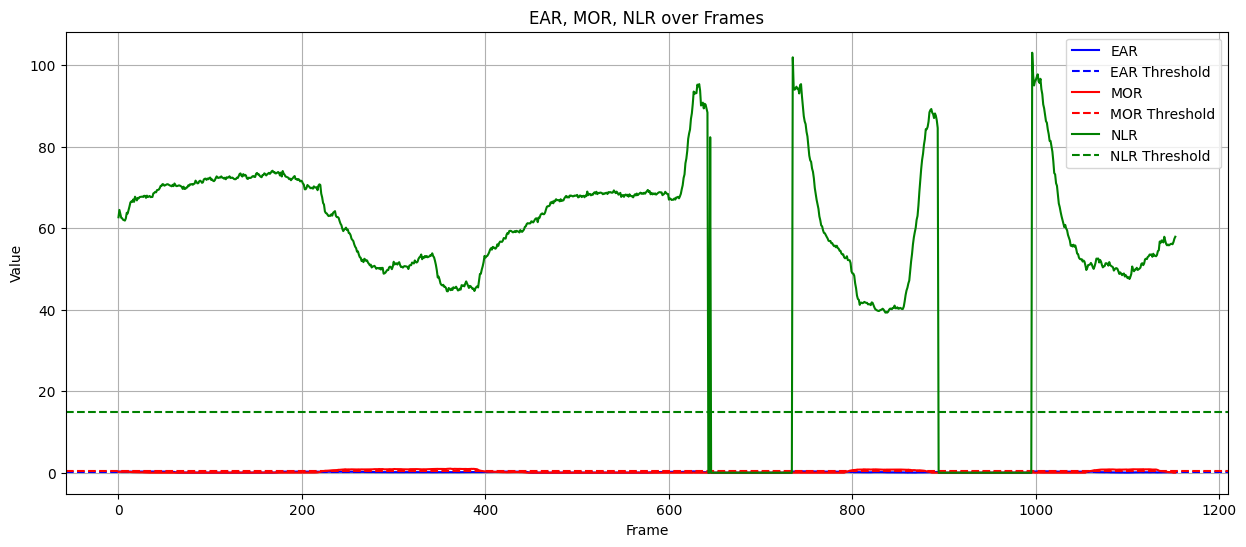

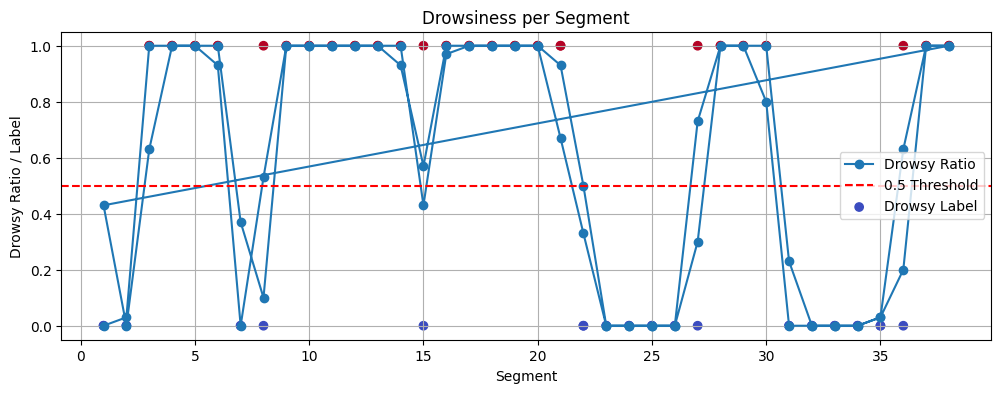

,Segment,Start_Time(s),End_Time(s),Drowsy_Ratio,Drowsy_Label
0,1,0.0,1.0,0.00,0
1,2,1.0,2.0,0.03,0
2,3,2.0,3.0,1.00,1
3,4,3.0,4.0,1.00,1
4,5,4.0,5.0,1.00,1


In [ ]:
import matplotlib.pyplot as plt


video_path = "/content/Himanshu_New_Dataset.mp4"   # change to dataset video path
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = 0
segment_count = 0

# For plotting
ear_list, mor_list, nlr_list, frame_ids = [], [], [], []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    h, w = frame.shape[:2]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    drowsy_frame = 0
    ear, mor, nlr = None, None, None

    if results.multi_face_landmarks:
        for landmarks in results.multi_face_landmarks:
            lm = landmarks.landmark
            # EAR
            left_eye_idx = [33,160,158,133,153,144]
            right_eye_idx = [362,385,387,263,373,380]
            ear = (eye_aspect_ratio(lm,left_eye_idx,w,h)+eye_aspect_ratio(lm,right_eye_idx,w,h))/2
            # MOR
            mor = mouth_opening_ratio(lm,w,h)
            # NLR
            nlr = nose_length_ratio(lm,w,h)

            # Threshold check
            if ear < EAR_THRESH or mor > MOR_THRESH or nlr < NLR_THRESH:
                drowsy_frame = 1

    # Save for plotting
    frame_ids.append(frame_count)
    ear_list.append(ear if ear else 0)
    mor_list.append(mor if mor else 0)
    nlr_list.append(nlr if nlr else 0)

    # Store frame result
    frame_buffer.append(drowsy_frame)
    frame_count += 1

    # Segment processing
    if len(frame_buffer) == FRAMES_PER_SEGMENT:
        segment_count += 1
        drowsy_ratio = sum(frame_buffer) / FRAMES_PER_SEGMENT
        segment_drowsy = 1 if drowsy_ratio > 0.5 else 0
        start_time = (frame_count - FRAMES_PER_SEGMENT) / fps
        end_time = frame_count / fps
        segment_results.append({
            "Segment": segment_count,
            "Start_Time(s)": round(start_time,2),
            "End_Time(s)": round(end_time,2),
            "Drowsy_Ratio": round(drowsy_ratio,2),
            "Drowsy_Label": segment_drowsy
        })
        frame_buffer.clear()

cap.release()

# ---- Save Results ----
df = pd.DataFrame(segment_results)
df.to_csv("drowsiness_results.csv", index=False)
print("Results saved to drowsiness_results.csv")

# ---- Plot EAR, MOR, NLR ----
plt.figure(figsize=(15,6))
plt.plot(frame_ids, ear_list, label="EAR", color="blue")
plt.axhline(y=EAR_THRESH, color="blue", linestyle="--", label="EAR Threshold")
plt.plot(frame_ids, mor_list, label="MOR", color="red")
plt.axhline(y=MOR_THRESH, color="red", linestyle="--", label="MOR Threshold")
plt.plot(frame_ids, nlr_list, label="NLR", color="green")
plt.axhline(y=NLR_THRESH, color="green", linestyle="--", label="NLR Threshold")
plt.xlabel("Frame")
plt.ylabel("Value")
plt.title("EAR, MOR, NLR over Frames")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Segment Drowsiness ----
plt.figure(figsize=(12,4))
plt.plot(df["Segment"], df["Drowsy_Ratio"], marker='o', label="Drowsy Ratio")
plt.axhline(y=0.5, color="red", linestyle="--", label="0.5 Threshold")
plt.scatter(df["Segment"], df["Drowsy_Label"], c=df["Drowsy_Label"], cmap="coolwarm", label="Drowsy Label")
plt.xlabel("Segment")
plt.ylabel("Drowsy Ratio / Label")
plt.title("Drowsiness per Segment")
plt.legend()
plt.grid(True)
plt.show()

df.head()

# Annotated Label

In [ ]:
# Install dependencies
!pip install mediapipe opencv-python-headless

import cv2
import mediapipe as mp
import numpy as np

# Initialize Mediapipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

# Thresholds
EAR_THRESH = 0.25
MOR_THRESH = 0.5
NLR_THRESH = 15

# Segment settings
FRAMES_PER_SEGMENT = 30   # ~1 sec at 30 fps

# ---- Feature Calculation Functions ----
def eye_aspect_ratio(landmarks, eye_indices, w, h):
    pts = [(int(landmarks[i].x*w), int(landmarks[i].y*h)) for i in eye_indices]
    A = np.linalg.norm(np.array(pts[1]) - np.array(pts[5]))
    B = np.linalg.norm(np.array(pts[2]) - np.array(pts[4]))
    C = np.linalg.norm(np.array(pts[0]) - np.array(pts[3]))
    return (A+B) / (2.0*C)

def mouth_opening_ratio(landmarks, w, h):
    top = np.array([landmarks[13].x*w, landmarks[13].y*h])
    bottom = np.array([landmarks[14].x*w, landmarks[14].y*h])
    left = np.array([landmarks[78].x*w, landmarks[78].y*h])
    right = np.array([landmarks[308].x*w, landmarks[308].y*h])
    return np.linalg.norm(top-bottom) / np.linalg.norm(left-right)

def nose_length_ratio(landmarks, w, h):
    tip = np.array([landmarks[1].x*w, landmarks[1].y*h])
    bridge = np.array([landmarks[168].x*w, landmarks[168].y*h])
    return np.linalg.norm(tip-bridge)

# ---- Load Dataset Video ----
video_path = "/content/Himanshu_New_Dataset.mp4"   # replace with your dataset video
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("annotated_output.mp4", fourcc, fps, (w, h))

frame_count = 0
drowsy_frames = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    drowsy_frame = False
    if results.multi_face_landmarks:
        for landmarks in results.multi_face_landmarks:
            lm = landmarks.landmark

            # EAR
            left_eye_idx = [33,160,158,133,153,144]
            right_eye_idx = [362,385,387,263,373,380]
            ear = (eye_aspect_ratio(lm,left_eye_idx,w,h)+eye_aspect_ratio(lm,right_eye_idx,w,h))/2
            # MOR
            mor = mouth_opening_ratio(lm,w,h)
            # NLR
            nlr = nose_length_ratio(lm,w,h)

            # Threshold check
            if ear < EAR_THRESH or mor > MOR_THRESH or nlr < NLR_THRESH:
                drowsy_frame = True

            # Overlay values
            cv2.putText(frame, f"EAR:{ear:.2f}", (30,40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            cv2.putText(frame, f"MOR:{mor:.2f}", (30,70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(frame, f"NLR:{nlr:.2f}", (30,100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Overlay Alert if drowsy
    if drowsy_frame:
        cv2.putText(frame, "DROWSINESS ALERT!", (100,200), cv2.FONT_HERSHEY_SIMPLEX,
                    1.2, (0,0,255), 3)

    # Write frame to output video
    out.write(frame)

    frame_count += 1

cap.release()
out.release()
print("✅ Annotated video saved as annotated_output.mp4")


✅ Annotated video saved as annotated_output.mp4


Everything is working great in this